# 5. Curve Interpolation

In [26]:
from fixedincome2025 import table

## What To Do With Missing Points? 

* When you compute the present value (PV) of your bond portfolio in practice, there will be missing points on the yield curve
* Treasury yield curve from [treasury.gov](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025): 

In [27]:
table('yc_09152025')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Imagine you have a Treasury bond that's 11M from its maturity, and the second-to-last coupon payment is 5M from now
* You need 5M point and 11M point to price the bond
* One also needs to take DCC into consideration when computing the year fractions ($T$ in the discount factor $e^{-TR(0, T)}$)

## A World of Curves

* Although we've been using the Treasury yield curve as our only example, in practice there are many other curves
    * Important ones are SOFR, Term SOFR, fed funds, LIBOR
    * SOFR is by far the most important one if you work in the rates business in a bank, more important than the Treasury yield curve
    * In the rates business, many curves are simply a spread curve plus the SOFR curve, spread from basis swap quotes
    * In a credit desk (trading credit projects including corporate bonds), corporate bond yield curves are a spread curve (known as the z-spread) plus the Treasury yield curve
* **Each curve has its own 6 representations**
* Below is how a SOFR curve should be interpolated

## Curve Interpolation Methods

* Curve interpolation is on the time-weighted zero rate $TR(0, T)$
* The interpolation method is
    * Linear interpolation in the short end
    * Cubic spline for the rest
* Cutoff is around 3Y, a decision more of an art than science

## Why Linear Interpolation on Time-Weighted Zero Rate? 

* Recall that
\begin{align*}
f(0, T) &= \frac{\partial }{\partial T} [TR(0, T)]
\end{align*}
* The reason people use linear interpolation on time-weighted zero rate in the short end is that we want its first derivative, the instantaneous forward curve ($f(0, T)$ for all $T$), to be a step function in the short end
* Linear interpolating function: Piecewise linear
* Step function: Piecewise constant
* The first derivative of a linear interpolating function is a step function

## Why Piecewise Constant $f(0, T)$? 

* Recall that
$$
L(0, T, T+\tau) = \frac{1}{\tau}\left(e^{\int_T^{T+\tau} f(0, u)\,du} - 1\right)
$$
* A variant of this formula is used to quote FRAs (and swaps)
* Recall the CME Term SOFR example

In [28]:
table('term_sofr')

,Term SOFR 1M,Term SOFR 3M,Term SOFR 6M,Term SOFR 12M
09-17-2025,4.13359 %,4.02304 %,3.85385 %,3.59516 %
09-16-2025,4.13584 %,4.02570 %,3.85447 %,3.60384 %
09-15-2025,4.14288 %,4.02330 %,3.84833 %,3.60702 %


## Why Piecewise Constant $f(0, T)$? (Cont.)

* Think of
$$
f(0, T) = L(0, T, T+\epsilon)
$$ 
for $\epsilon=$1d
* Market quote of $f(0, T)$, like $L(0, T, T+\tau)$, is implied by the prices of market instruments and cannot be chosen subjectively
    * It is not a matter of opinion
    * Posting an incorrect quote creates an arbitrage opportunity

* $f(0, T)$ is the market anticipated time-$T$ (in the future) daily SOFR fixings, which should stay constant between fed rate decisions

* The discontinuities are [FOMC meeting dates](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

## Linear Interpolation on Time-Weighted Zero Rate

* In conclusion, it makes sense for the $TR(0, T)$ curve to be a linear function between FOMC meetings dates in the short end
* The slope of $TR(0, T)$ at $T=T^*$ equals $f(0, T^*)$, which is the anticipated SOFR daily fixing level at $T^*$
* FOMC meeting schedule is not determined for 3Y out, why not just make the curve continuous and smooth? 

## Short End Curve Interpolation: Example I

* Assuming: 
    * Today's SOFR yield curve is as below
    * From the 2M point to the 3M point there will be no FOMC meetings
    * 30/360 DCC
* What should the yield be at the 2.5M point?

In [29]:
table('yc_sofr_example')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Between 2M and 3M, $TR(0, T)$ must be a linear function, so we have 
\begin{align*}
&\left(\frac{2}{12}\times 4.17\% + \frac{3}{12}\times 4.06\%\right)/2 = \frac{2.5}{12} \times R\\
\end{align*}
and hence $R = 4.104\%$

## Short End Curve Interpolation: Exercise I

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 2M point and the 3M point there will be no FOMC meetings
    * 30/360 DCC
* What should the yield be at the 2.333M point?

In [30]:
table('yc_sofr_exercise')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.20%,4.19%,4.15%,4.04%,4.00%,3.81%,3.62%,3.51%,3.47%


## Short End Curve Interpolation: Answer I

* Between 2M and 3M, $TR(0, T)$ must be a linear function and forward rates are assumed constant, so we have:

$$
f(0, 2M) = f(0, 2.333M) = f(0, 3M) = (4.04 \% \times (3/12) - 4.15 \% \times (2/12)) / (1/12) = 3.82 \%
$$

$$
R(2.333M) = (2/12 \times 4.15\% + (2.333 - 2) / 12 \times 3.82 \%) / (2.333/12) = 4.103 \%
$$


## Short End Curve Interpolation: Example II

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 1.5M point and the 2M point there will be no FOMC meetings
    * Between the 3M point and the 3.5M point there will be no FOMC meetings
    * There is an FOMC meeting at the 2.5M point where the consensus is that the Fed will $100\%$ cut its rate by 25 bps
    * SOFR daily rates moves at the same time by the same amount as the fed funds rate
    * 30/360 DCC
* What should the yield be at the 3.333M point?

In [31]:
table('yc_sofr_example')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


## Short End Curve Interpolation: Example II (Cont.)

In [32]:
table('yc_sofr_example')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Recall that the slope of $TR(0, T)$ in the interval [1.5M, 2M] is $f(0, T)$, the anticipated SOFR daily fixing level in that interval. Numerically, it's
\begin{align*}
\frac{2\times 4.17\% - 1.5\times 4.21\%}{0.5} = 4.05\%
\end{align*}

* Similarly, the slope of $TR(0, T)$ in the interval [3M, 3.5M] is the anticipated SOFR daily fixings in that interval, which is $4.05\% - 0.25\% = 3.8\%$

* The slope can also be written in terms of yield at the 3M point and the 3.3333M point as
\begin{align*}
\frac{3.3333\times R - 3\times 4.06}{0.3333}, 
\end{align*}
which we know should be $3.8\%$. Thus $R$ can be backed out to be $4.034\%$

## Short End Curve Interpolation: Exercise II

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 1.5M point and the 2M point there will be no FOMC meetings
    * Between the 3M point and the 3.6M point there will be no FOMC meetings
    * There is an FOMC meeting at the 2.5M point where the consensus is that the Fed will $100\%$ cut its rate by 25 bps
    * SOFR daily rates moves at the same time by the same amount as the fed funds rate
    * 30/360 DCC
* What should the yield be at the 3.5M point?

In [33]:
table('yc_sofr_exercise')

,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
Yield,4.20%,4.19%,4.15%,4.04%,4.00%,3.81%,3.62%,3.51%,3.47%


## Jump Size Always (Multiple of) 25 Bps? 

* No
* Above computation only works if the market is in good agreement on what will happen in the next FOMC meeting
* Only in such situation you know the jump size of the step function
* When market is not in good agreement, the jump size is an average of participants' view

In [34]:
table('forward_rate_jump_size')

,10/29/2025,12/10/2025,1/28/2026,3/18/2026,4/29/2026
Meeting Date,,,,,
Jump Size (bps),-22.5,-17.9,-12.1,-9.5,-6.2


## Is the Market Often in Good Agreement?

* Sometimes
* [Federal Funds Target Rate Chart](https://fred.stlouisfed.org/series/DFEDTARU)
* When the market is in good agreement, it's usually only for the next meeting
* The meetings after that will be too far
* Fed rate decision is driven by unpredictable economic data
    * inflation, labor market, GDP growth, etc.
* [The CME FedWatch Tool](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html)

## Unpredictability of the Economic Data

* Weather data is significantly easier to predict than economic data
    * Weather data: Complex but understood physical processes
    * Economic data: Unpredictable and irrational human behavior
* Economic data is becoming more unpredictable due to 
    * Decline in the quality and reliability of U.S. economic data caused by budget cuts and falling survey response rates
    * Unexpected global events like pandemics and geopolitical conflicts
    * Lack of clarity surrounding government policies
* Economic uncertainty can harm business investment and hiring, as businesses struggle to plan in a constantly shifting environment

## Extrapolation at the Short End

* The assumption that $TR(0, T)$ is piecewise linear leads to flat extrapolation on the left
* Let $T$ be the first (shortest) term where we have a quote. Consider $t<T$: 
\begin{align*}
tR(0, t) = \frac{t}{T} \times TR(0, T) + \frac{T-t}{T} \times 0 = t R(0, T)
\end{align*}
Thus
$$
R(0, t) = R(0, T) \qquad\forall t\in [0, T]
$$
* In particular, the overnight rate $R(0, \text{1D}) = R(0, T)$

## What About Long End of the Curve?

* For yield curve that's 3Y away, the same state data $TR(0, T)$ is used in interpolation
* We want forward rate to be continuous and smooth
    * Smooth means 1st order derivative is continuous
\begin{align*}
f(0, T) &= \frac{\partial }{\partial T} [TR(0, T)]
\end{align*}
* We need the $TR(0, T)$ curve to be continuous and have continuous 1st and 2nd derivatives

## Differentiation and Smoothness 

* Integrating a piecewise function removes discontinuities
* Jumps in the integrand (blue) turn into kinks in the integral (orange)

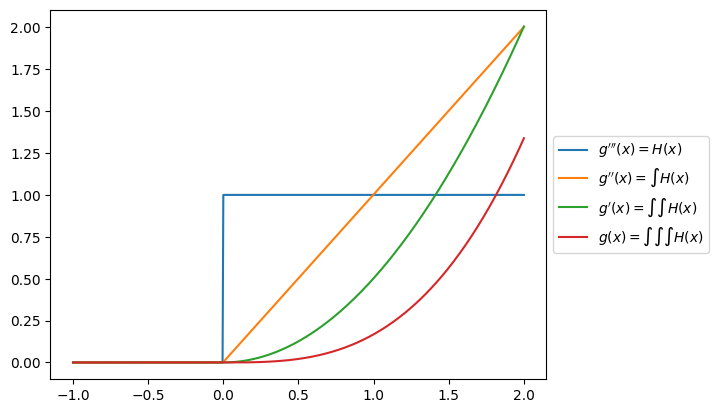

In [35]:
from gfuncpy import gfunc, Identity

@gfunc
def H(x):
    if x < 0:
        return 0
    else:
        return 1

x = Identity([-1, 2])

gppp = H(x)
gpp  = H(x).int()
gp   = H(x).int().int()
g    = H(x).int().int().int()

gppp.plot(label=r"$g'''(x) = H(x)$")
gpp.plot(label=r"$g''(x) = \int H(x)$")
gp.plot(label=r"$g'(x) = \int\int H(x)$")
g.plot(label=r"$g(x) = \int\int\int H(x)$")

## [GFuncPy](https://gfuncpy.readthedocs.io/en/latest/)

## Piecewise Cubic Functions

* The more times you integrate a piecewise function, the more smooth it becomes
* We want $f(0, T)$ to at least look like the green curve, no kinks, so $TR(0, T)$ will look like the red curve, a piecewise cubic function

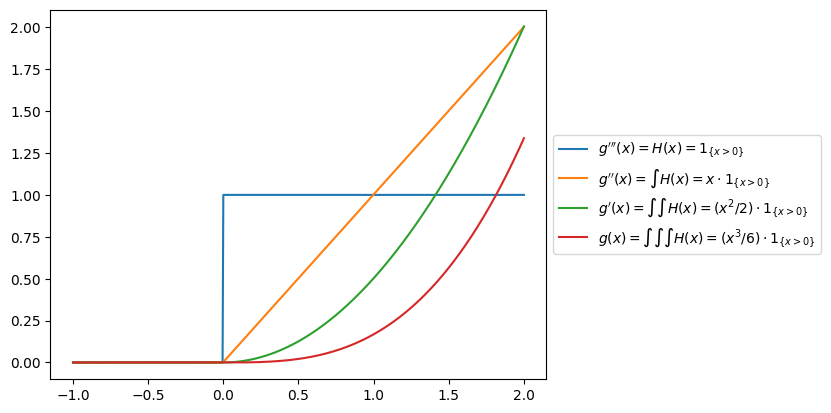

In [36]:
from gfuncpy import gfunc, Identity

@gfunc
def H(x):
    if x < 0:
        return 0
    else:
        return 1

x = Identity([-1, 2])

gppp = H(x)
gpp  = H(x).int()
gp   = H(x).int().int()
g    = H(x).int().int().int()

gppp.plot(label=r"$g'''(x) = H(x) = 1_{\{x>0\}}$")
gpp.plot(label=r"$g''(x) = \int H(x) = x\cdot 1_{\{x>0\}}$")
gp.plot(label=r"$g'(x) = \int\int H(x) = (x^2/2)\cdot 1_{\{x>0\}}$")
g.plot(label=r"$g(x) = \int\int\int H(x) = (x^3/6)\cdot 1_{\{x>0\}}$")

## Function with Smoothness $k$

* A function of class $C^k$ is a function that has continuous derivatives up to the $k$-th order
    * $f(x)\in C^2$ means all $f(x)$, $f'(x)$ and $f''(x)$ are continuous but not $f'''(x)$
    * $f(x)\in C^0$ means $f(x)$ is continuous but not $f'(x)$
    * In fact, a $C^0$ function must be non-differentiable at some point (at the kinks)
<!-- * We say a function $f(x)$ has smoothness $k$ if $f(x)\in C^k$ -->

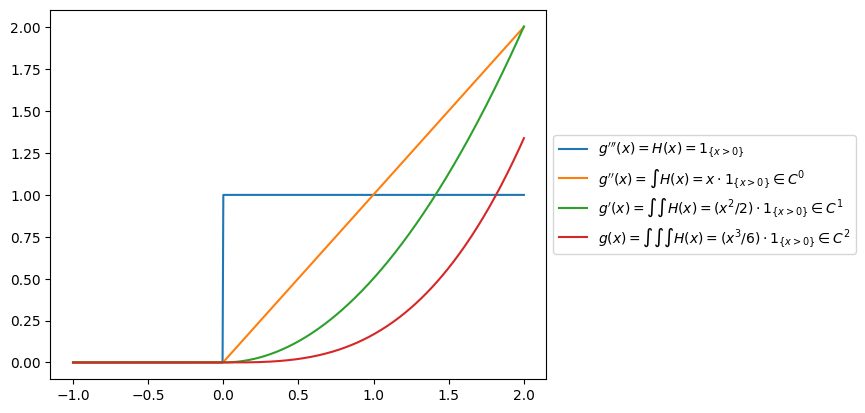

In [37]:
from gfuncpy import gfunc, Identity

@gfunc
def H(x):
    if x < 0:
        return 0
    else:
        return 1

x = Identity([-1, 2])

gppp = H(x)
gpp  = H(x).int()
gp   = H(x).int().int()
g    = H(x).int().int().int()

gppp.plot(label=r"$g'''(x) = H(x) = 1_{\{x>0\}}$")
gpp.plot(label=r"$g''(x) = \int H(x) = x\cdot 1_{\{x>0\}}\in C^0$")
gp.plot(label=r"$g'(x) = \int\int H(x) = (x^2/2)\cdot 1_{\{x>0\}}\in C^1$")
g.plot(label=r"$g(x) = \int\int\int H(x) = (x^3/6)\cdot 1_{\{x>0\}}\in C^2$")

## Another Way To Increase Smoothness

* Multiplying a piecewise function $f(x)$ with discontinuity $c$ by a function $g(x)$ that goes through 0 at $c$ (meaning $g(c)=0$) removes the discontinuity
    * In the below example we have $c=0$ and $g(x) = x$
* The jump in the blue curve turns into a kink in the orange

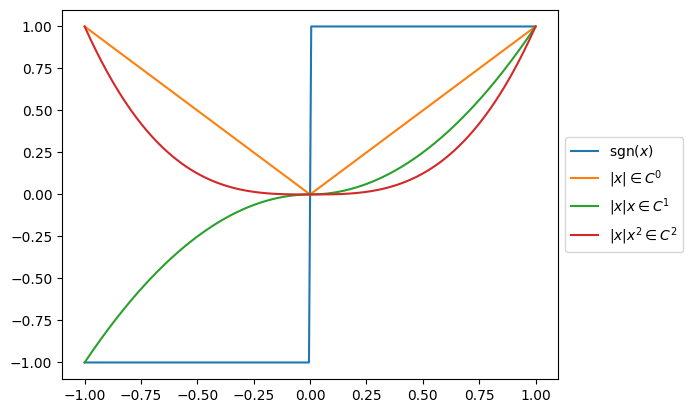

In [38]:
from gfuncpy import Identity, abs, sign

x = Identity([-1, 1])

sign(x).plot(label=r'$\text{sgn}(x)$')
abs(x).plot(label=r'$|x| \in C^0$')
(abs(x)*x).plot(label=r'$|x|x \in C^1$')
(abs(x)*(x**2)).plot(label=r'$|x|x^2 \in C^2$')

## Interpolating Cubic Spline

* An interpolating cubic spline $s(x)$ is a piecewise function, a $C^2$ function
* The curve is a cubic function $a_j x^3 + b_j x^2 + c_j x + d_j$ in each subinterval
* Coefficients $\{a_j\}, \{b_j\}, \{c_j\}, \{d_j\}$ are chosen to make $s(x), s'(x), s''(x)$ continuous
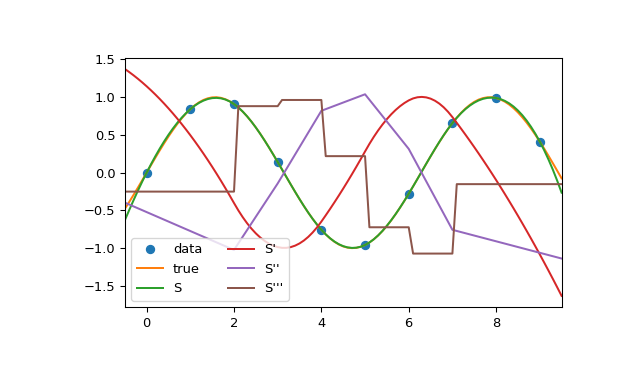
* Plot from [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)

## Cubic Spline (Classic) Construction

* One way to construct $s(x)$ is to list equations for all coefficients and solve the system
* If we have $n$ subintervals, there will be $4n$ coefficients

* Each cubic polynomial has to go through the two end points in the corresponding subinterval, giving $2n$ equations

* Continuity of $s'(x)$ at the *knots* ($\{x_j\}_{j=0}^n$) gives $n-1$ equations

* Continuity of $s''(x)$ at the *knots* gives $n-1$ equations

* We are left with $4n - 2n - (n-1) - (n-1) = 2$ degrees of freedom for boundary contitions
    * Natural boundary condition: $s''(x_0) = s''(x_n) = 0$

## Cubic B-Spline Construction

* A better way, known as the basis-spline, or the B-spline, is to construct $s(x)$ as a linear combination of basis functions
$$
s(x) = \sum_{j=0}^n c_j B_{j,3}(x)
$$
* Basis functions can be precomputed and stored, speeding up the construction of $s(x)$
* Easy to add/remove knots, it will be just reconstructing a few basis functions in the neighborhood that needs change
* De Boor's Algorithm
$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$

## De Boor's Algorithm: Piecewise Constant

* Assuming $x_j = j$, a uniform grid with grid spacing 
$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$

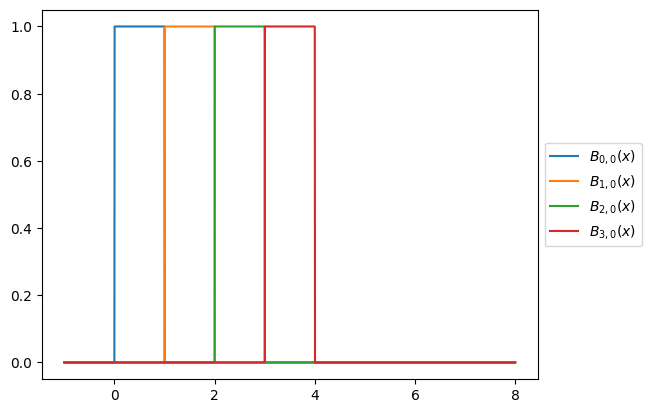

In [39]:
from functools import partial
from gfuncpy import gfunc

def B(x, idx):
    if idx < x <= idx + 1:
        return 1
    else: 
        return 0

B_00 = gfunc(partial(B, idx=0))
B_10 = gfunc(partial(B, idx=1))
B_20 = gfunc(partial(B, idx=2))
B_30 = gfunc(partial(B, idx=3))
B_40 = gfunc(partial(B, idx=4))
B_50 = gfunc(partial(B, idx=5))
B_60 = gfunc(partial(B, idx=6))

x = Identity([-1, 8])

B_00(x).plot(label=r'$B_{0, 0}(x)$')
B_10(x).plot(label=r'$B_{1, 0}(x)$')
B_20(x).plot(label=r'$B_{2, 0}(x)$')
B_30(x).plot(label=r'$B_{3, 0}(x)$')

## De Boor's Algorithm: Piecewise Linear, $C^0$

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=1$: 
\begin{align*}
B_{0,1}(x) &= (x-0) B_{0,0}(x) + (2-x) B_{1,0}(x)\qquad i=0, \\
B_{1,1}(x) &= (x-1) B_{1,0}(x) + (3-x) B_{2,0}(x)\qquad i=1, \\
B_{2,1}(x) &= (x-2) B_{2,0}(x) + (4-x) B_{3,0}(x)\qquad i=2, \\
B_{3,1}(x) &= (x-3) B_{3,0}(x) + (5-x) B_{4,0}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Linear, $C^0$

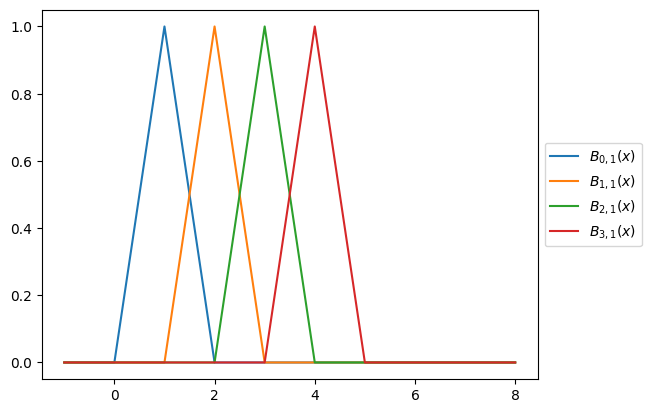

In [40]:
B_01 = (x-0)*B_00(x) + (2-x)*B_10(x)
B_11 = (x-1)*B_10(x) + (3-x)*B_20(x)
B_21 = (x-2)*B_20(x) + (4-x)*B_30(x)
B_31 = (x-3)*B_30(x) + (5-x)*B_40(x)
B_41 = (x-4)*B_40(x) + (6-x)*B_50(x)
B_51 = (x-5)*B_50(x) + (7-x)*B_60(x)

B_01.plot(label=r'$B_{0, 1}(x)$')
B_11.plot(label=r'$B_{1, 1}(x)$')
B_21.plot(label=r'$B_{2, 1}(x)$')
B_31.plot(label=r'$B_{3, 1}(x)$')

## De Boor's Algorithm: Piecewise Quadratic, $C^1$

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=2$: 
\begin{align*}
B_{0,2}(x) &= \left(\frac{x-0}{2}\right) B_{0,1}(x) + \left(\frac{3-x}{2}\right) B_{1,1}(x)\qquad i=0, \\
B_{1,2}(x) &= \left(\frac{x-1}{2}\right) B_{1,1}(x) + \left(\frac{4-x}{2}\right) B_{2,1}(x)\qquad i=1, \\
B_{2,2}(x) &= \left(\frac{x-2}{2}\right) B_{2,1}(x) + \left(\frac{5-x}{2}\right) B_{3,1}(x)\qquad i=2, \\
B_{3,2}(x) &= \left(\frac{x-3}{2}\right) B_{3,1}(x) + \left(\frac{6-x}{2}\right) B_{4,1}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Quadratic, $C^1$

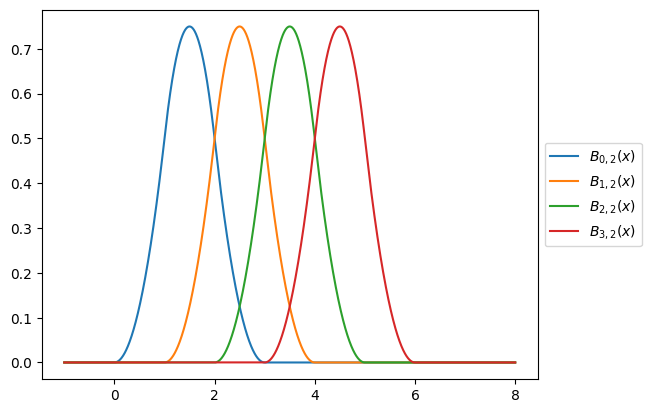

In [41]:
B_02 = ((x-0)*B_01 + (3-x)*B_11)/2
B_12 = ((x-1)*B_11 + (4-x)*B_21)/2
B_22 = ((x-2)*B_21 + (5-x)*B_31)/2
B_32 = ((x-3)*B_31 + (6-x)*B_41)/2
B_42 = ((x-4)*B_41 + (7-x)*B_51)/2

B_02.plot(label=r'$B_{0, 2}(x)$')
B_12.plot(label=r'$B_{1, 2}(x)$')
B_22.plot(label=r'$B_{2, 2}(x)$')
B_32.plot(label=r'$B_{3, 2}(x)$')

## De Boor's Algorithm: Piecewise Cubic, $C^2$

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=3$: 
\begin{align*}
B_{0,3}(x) &= \left(\frac{x-0}{3}\right) B_{0,2}(x) + \left(\frac{4-x}{3}\right) B_{1,2}(x)\qquad i=0, \\
B_{1,3}(x) &= \left(\frac{x-1}{3}\right) B_{1,2}(x) + \left(\frac{5-x}{3}\right) B_{2,2}(x)\qquad i=1, \\
B_{2,3}(x) &= \left(\frac{x-2}{3}\right) B_{2,2}(x) + \left(\frac{6-x}{3}\right) B_{3,2}(x)\qquad i=2, \\
B_{3,3}(x) &= \left(\frac{x-3}{3}\right) B_{3,2}(x) + \left(\frac{7-x}{3}\right) B_{4,2}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Cubic, $C^2$

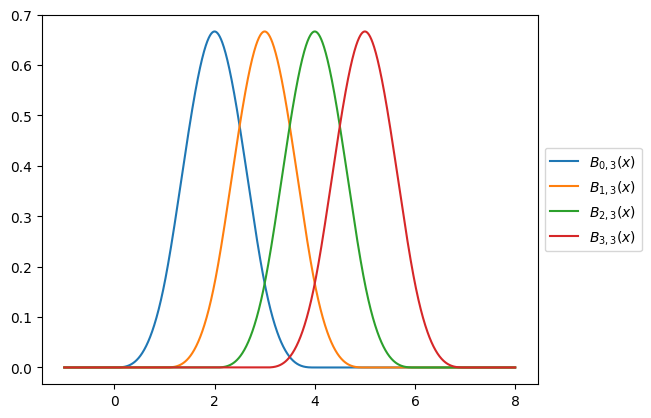

In [42]:
B_03 = ((x-0)*B_02 + (4-x)*B_12)/3
B_13 = ((x-1)*B_12 + (5-x)*B_22)/3
B_23 = ((x-2)*B_22 + (6-x)*B_32)/3
B_33 = ((x-3)*B_32 + (7-x)*B_42)/3

B_03.plot(label=r'$B_{0, 3}(x)$')
B_13.plot(label=r'$B_{1, 3}(x)$')
B_23.plot(label=r'$B_{2, 3}(x)$')
B_33.plot(label=r'$B_{3, 3}(x)$')

## De Boor's Algorithm: Why Does It Work?

* From piecewise linear ($C^0$) to piecewise quadratic ($C^1$)
$$
B_{0,2}(x) = \underline{x B_{0,1}(x)/2} + (3-x) B_{1,1}(x)/2
$$

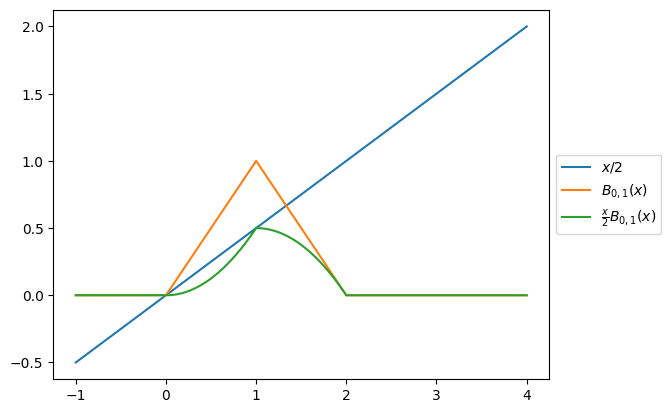

In [61]:
x = Identity([-1, 4])

B_01 = (x-0)*B_00(x) + (2-x)*B_10(x)
B_11 = (x-1)*B_10(x) + (3-x)*B_20(x)


(x/2).plot(label=r'$x/2$')
B_01.plot(label=r'$B_{0, 1}(x)$')

((x/2)*B_01).plot(label=r'$\frac{x}{2}B_{0, 1}(x)$')

## De Boor's Algorithm: Why Does It Work? (Cont.)

* From piecewise linear ($C^0$) to piecewise quadratic ($C^1$)
$$
B_{0,2}(x) = \underline{x B_{0,1}(x)/2} + (3-x) B_{1,1}(x)/2
$$

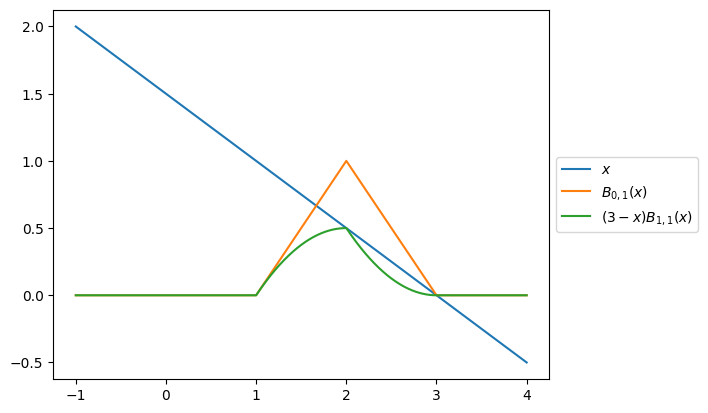

In [62]:
((3-x)/2).plot(label=r'$x$')
B_11.plot(label=r'$B_{0, 1}(x)$')

(((3-x)/2)*B_11).plot(label=r'$(3-x)B_{1, 1}(x)$')

## De Boor's Algorithm: Why Does It Work? (Cont..)

* From piecewise linear ($C^0$) to piecewise quadratic ($C^1$)
$$
B_{0,2}(x) = x B_{0,1}(x)/2~{\color{red}+}~(3-x) B_{1,1}(x)/2
$$

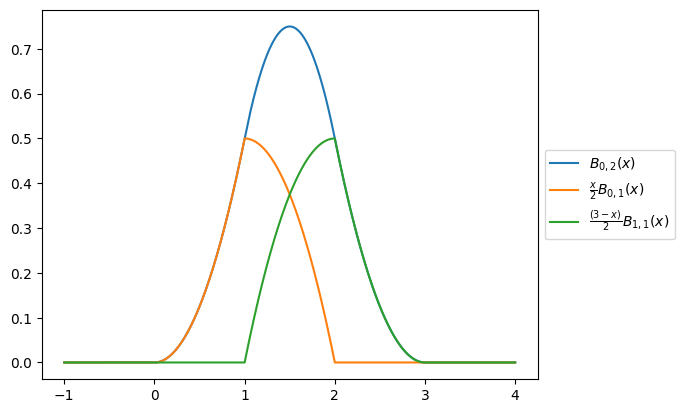

In [65]:
((x*B_01 + (3-x)*B_11)/2).plot(label=r'$B_{0, 2}(x)$')
(x*B_01/2).plot(label=r'$\frac{x}{2}B_{0, 1}(x)$')
((3-x)*B_11/2).plot(label=r'$\frac{(3-x)}{2}B_{1, 1}(x)$')

## De Boor's Algorithm: Non-Uniform Grid

$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$

* The algorithm does not say anything about what the grid should be
* In particular, the grid does not have to be uniform
* In the market, liquid points on the curve (where we have reliable real time data) do not form a uniform grid

In [ ]:
table('yc_long_end')

## [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) Example

```python
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([3, 5, 7, 10, 20, 30])
R = np.array([3.63, 3.75, 3.95, 4.18, 4.73, 4.76])/100

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    return cs(x)

T = Identity([3, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()
```

## [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) Example (Cont.)

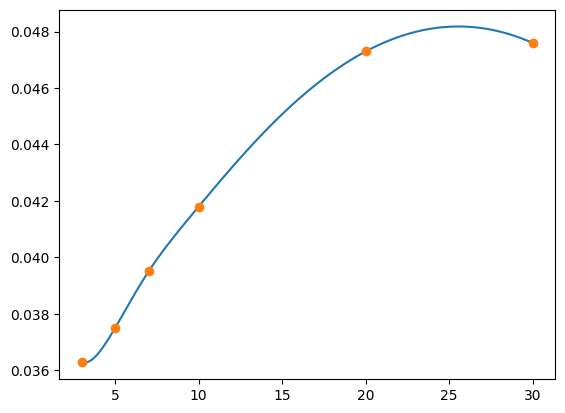

In [81]:
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([3, 5, 7, 10, 20, 30])
R = np.array([3.63, 3.75, 3.95, 4.18, 4.73, 4.76])/100

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    return cs(x)

T = Identity([3, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()

## Front End of the Curve

```python 
import numpy as np

T_knots = np.array([1/365, 0.083333, 0.125, 0.16667, 0.25, 0.33333, 0.5, 1, 2, 3])
R = np.array([4.22, 4.22, 4.14, 4.11, 4.02, 3.95, 3.81, 3.66, 3.60, 3.63])/100

@gfunc
def TR(x):
    return np.interp(x, T_knots, T_knots*R)  # time weighted zero rate

T = Identity([0, 3])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()
```

## Front End of the Curve (Cont.)

* In this toy example we assume the discontinuities are 1M, 1.5M, 2M, 3M, 4M, 6M, 1Y, 2Y and 3Y (it was supposed to be the FOMC meeting dates at the very short end)
* Recall that without a quote, it's flat extrapolation on the left

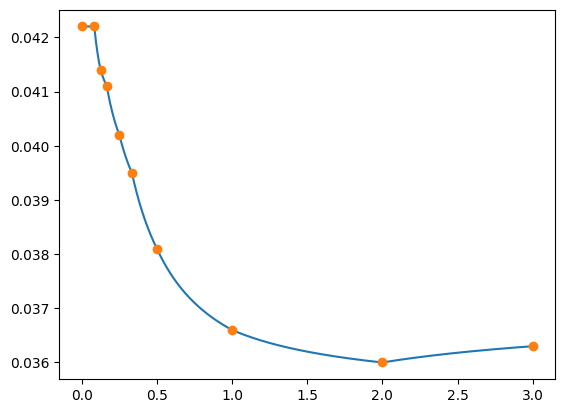

In [87]:
import numpy as np

T_knots = np.array([0, 0.083333, 0.125, 0.16667, 0.25, 0.33333, 0.5, 1, 2, 3])
R = np.array([4.22, 4.22, 4.14, 4.11, 4.02, 3.95, 3.81, 3.66, 3.60, 3.63])/100

@gfunc
def TR(x):
    return np.interp(x, T_knots, T_knots*R)  # time weighted zero rate

T = Identity([0, 3])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()

## Entire Curve


```python
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([1/365, 0.083333, 0.125, 0.16667, 0.25, 0.33333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
R = np.array([4.22, 4.22, 4.14, 4.11, 4.02, 3.95, 3.81, 3.66, 3.60, 3.63, 3.75, 3.95, 4.18, 4.73, 4.76])/100

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    if x<3: 
        return np.interp(x, T_knots, T_knots*R)
    else:
        return cs(x)

T = Identity([0, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()
```

## Entire Curve (Cont.)

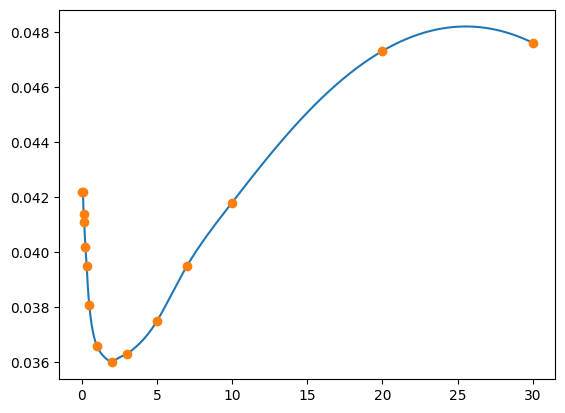

In [82]:
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([1/365, 0.083333, 0.125, 0.16667, 0.25, 0.33333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
R = np.array([4.22, 4.22, 4.14, 4.11, 4.02, 3.95, 3.81, 3.66, 3.60, 3.63, 3.75, 3.95, 4.18, 4.73, 4.76])/100

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    if x<3: 
        return np.interp(x, T_knots, T_knots*R)
    else:
        return cs(x)

T = Identity([0, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()